# iPhone Calculator

In [1]:
!pip install customtkinter

In [2]:
# size
APP_SIZE = (400,700)
MAIN_ROWS = 7
MAIN_COLUMNS = 4

# text
FONT = "Helvetica"
OUTPUT_FONT_SIZE = 70
NORMAL_FONT_SIZE = 32

STYLING = {
    "gap": 0.5,
    "corner-radius": 0}

NUM_POSITIONS = {
    ".":{"col":2, "row":6, "span":1},
    0: {"col":0, "row":6, "span":2},
    1: {"col":0, "row":5, "span":1},
    2: {"col":1, "row":5, "span":1},
    3: {"col":2, "row":5, "span":1},
    4: {"col":0, "row":4, "span":1},
    5: {"col":1, "row":4, "span":1},
    6: {"col":2, "row":4, "span":1},
    7: {"col":0, "row":3, "span":1},
    8: {"col":1, "row":3, "span":1},
    9: {"col":2, "row":3, "span":1}
    }

MATH_POSITIONS = {
    "/":{"col":3, "row":2,"character":"/","image path":None},
    "*":{"col":3, "row":3,"character":"x","image path":None},
    "-":{"col":3, "row":4,"character":"-","image path":None},
    "=":{"col":3, "row":5,"character":"=","image path":None},
    "+":{"col":3, "row":6,"character":"+","image path":None}
}

OPERATORS = {
    "clear": {"col":0,"row":2,"text":"AC","image path":None},    
    "invert": {"col":1,"row":2,"text":"+/-","image path":None},    
    "percent": {"col":2,"row":2,"text":"%","image path":None}    
}

COLORS = {
    "light-gray":{"fg":("#505050","#D4D4D2"), "hover":("#686868","#efefed"), "text":("white","black")},
    "dark-gray":{"fg":("#D4D4D2","#505050"), "hover":("#efefed","#686868"), "text":("black","white")},
    "orange":{"fg":"#FF9500", "hover":"#ffb143", "text":("black","white")},
    "orange-highlight":{"fg":"white", "hover":"white", "text":("black","FF9500")}
}

TITLE_BAR_HEX_COLORS = {
    "dark": 0x00000000,
    "light": 0x00EEEEEE
}

BLACK = "#000000"
WHITE = "#EEEEEE"


#####################################


import tkinter
from typing import Callable, Optional, Tuple, Union
import customtkinter as ctk
from customtkinter.windows.widgets.font import CTkFont
from customtkinter.windows.widgets.image import CTkImage
import darkdetect
from PIL import Image

try:
    from ctypes import windll, byref, sizeof,c_int
except:
    pass


class calculator(ctk.CTk):
    def __init__(self,is_dark):
        
        # setup
        super().__init__(fg_color=(WHITE, BLACK))
        ctk.set_appearance_mode(f'{"dark" if is_dark else "light"}')
        self.geometry(f'{APP_SIZE[0]}x{APP_SIZE[1]}')
        self.resizable(False,False)
        self.title('')
        self.iconbitmap('empty.ico')
        self.title_bar_color(is_dark)
        
        # grid layout
        self.rowconfigure(list(range(MAIN_ROWS)),weight=1,uniform="a")
        self.columnconfigure(list(range(MAIN_COLUMNS)),weight=1,uniform="a")
        
        # data
        self.result_string = ctk.StringVar(value="0")
        self.formula_string = ctk.StringVar(value="")
        self.display_nums = []
        self.full_operation = []
        
        # widgets
        self.create_widgets()
        
        self.mainloop()

    def title_bar_color(self, is_dark):
        try:
            HWND = windll.user32.GetParent(self.winfo_id())
            DWMDA_ATTRIBUTE = 35
            COLOR = TITLE_BAR_HEX_COLORS["dark"] if is_dark else TITLE_BAR_HEX_COLORS["light"]
            windll.dwmapi.DwmSetWindowAttribute(HWND,DWMDA_ATTRIBUTE,byref(c_int(COLOR)),sizeof(c_int))
        except:
            pass
    
    def create_widgets(self):
        # fonts
        main_font = ctk.CTkFont(family=FONT, size=NORMAL_FONT_SIZE)
        result_font = ctk.CTkFont(family=FONT, size=OUTPUT_FONT_SIZE)
        
        # output labels
        OutputLabel(self,0,"se",main_font,self.formula_string)
        OutputLabel(self,1,"e",result_font,self.result_string)
        
        # clear (AC) button
        Button(
            parent=self,
            func = self.clear,
            text=OPERATORS["clear"]["text"],
            col=OPERATORS["clear"]["col"],
            row=OPERATORS["clear"]["row"],
            font=main_font,
            span=1)
        
        # percentage button
        Button(
            parent=self,
            func = self.percent,
            text=OPERATORS["percent"]["text"],
            col=OPERATORS["percent"]["col"],
            row=OPERATORS["percent"]["row"],
            font=main_font,
            span=1)
        
        # invert button
        Button(
            parent=self,
            func = self.invert,
            text=OPERATORS["invert"]["text"],
            col=OPERATORS["invert"]["col"],
            row=OPERATORS["invert"]["row"],
            font=main_font,
            span=1)
        
        # num buttons
        for num, data in NUM_POSITIONS.items():
            NumButton(
                parent=self,
                text=num,
                func=self.num_press,
                col=data["col"],
                row=data["row"],
                font=main_font,
                span=data["span"])
        
        # math buttons
        for operator, data in MATH_POSITIONS.items():
            MathButton(
                parent = self,
                text = data["character"],
                operator = operator,
                func = self.math_press,
                col = data["col"],
                row = data["row"],
                span = 1,
                font = main_font)
        
    def clear(self):
        # clear the output
        self.result_string.set(0)
        self.formula_string.set("")
        
        # clear the data
        self.display_nums.clear()
        self.full_operation.clear()
    
    def percent(self):
        if self.display_nums:
            # get the percentage number 
            current_number = float("".join(self.display_nums))
            percent_number = current_number / 100
            
            # update the data and output
            self.display_nums = list(str(percent_number))
            self.result_string.set("".join(self.display_nums))
    
    def invert(self):
        current_number="".join(self.display_nums)
        if current_number:
            if float(current_number) > 0:
                self.display_nums.insert(0,"-")
            else:
                del self.display_nums[0]
            self.result_string.set("".join(self.display_nums))
    
    def num_press(self,value):
        self.display_nums.append(str(value))
        full_number = "".join(self.display_nums)
        self.result_string.set(full_number)
    
    def math_press(self,value):
        current_number = "".join(self.display_nums) 
        
        if current_number:
            self.full_operation.append(current_number)
            
            if value != "=":
                # update data
                self.full_operation.append(value)
                self.display_nums.clear()
                # update output
                self.result_string.set("")
                self.formula_string.set(" ".join(self.full_operation))
            
            else:
                formula = " ".join(self.full_operation)
                result = eval(formula)
                
                # format the result
                if isinstance(result,float):
                    
                    if result.is_integer():
                        result = int(result)
                    
                    else:
                        result = round(result,3)
                
                # update data
                self.full_operation.clear()
                self.display_nums = [str(result)]
                
                # update my output
                self.result_string.set(result)
                self.formula_string.set(formula)
                
                # clear the full operation list
                 

class OutputLabel(ctk.CTkLabel):
    def __init__(self, parent, row, anchor, font,string_var):
        super().__init__(parent,font=font, textvariable = string_var)
        self.grid(column = 0, columnspan = 4, row=row, sticky = anchor, padx = 10)

class Button(ctk.CTkButton):
    def __init__(self,parent,text,func,col,row,font,span,color = "dark-gray"):
        super().__init__(
            master=parent,
            text=text,
            command=func,
            corner_radius=STYLING["corner-radius"],
            font=font,
            fg_color=COLORS[color]["fg"],
            hover_color=COLORS[color]["hover"],
            text_color= COLORS[color]["text"])
        
        self.grid(column = col, row = row, columnspan=span, sticky = "NSEW",padx=STYLING["gap"],pady=STYLING["gap"])       

class NumButton(Button):
    def __init__(self,parent,text,func,col,row,font,span,color = "light-gray"):
        super().__init__(
        parent=parent,
        text=text,
        func=lambda: func(text),
        col=col,
        row=row,
        font=font,
        color=color,
        span=span        
        )
        
        self.grid(column=col,row=row,columnspan=span,sticky="NSEW",padx=STYLING["gap"],pady=STYLING["gap"])

class MathButton(Button):
    def __init__(self, parent, text, operator, func, col, row, font, span, color = "orange"):
        super().__init__(
        parent = parent,
        text = text,
        func = lambda: func(operator),
        col = col,
        row = row,
        font = font,
        span=span,
        color = color)

# class ImageButton(ctk.CTkButton):
#     def __init__(self,parent,text,func,col,row,font,image,color = "dark-gray"):
#         super().__init__(
#         master=parent,
#         command=func,
#         text=text,
#         image=image,
#         corner_radius=STYLING["corner-radius"],
#         fg_color=COLORS[color]["fg"],
#         hover_color=COLORS[color]["hover"],
#         text_color= COLORS[color]["text"])
        
#         self.grid(column=col,row=row,sticky="NSEW",padx=STYLING["gap"],pady=STYLING["gap"])


# print(darkdetect.isDark())
if __name__ == "__main__":
    calculator(darkdetect.isDark())
    # calculator(True)

# Output

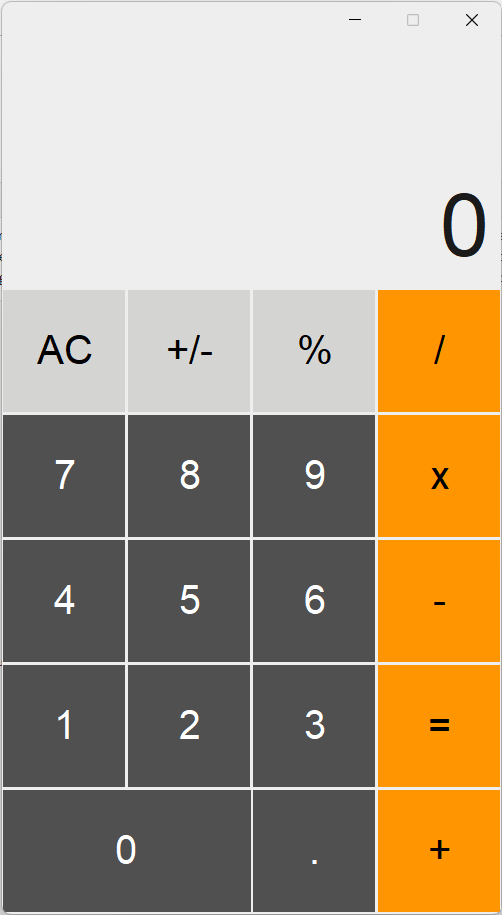